In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_df = "/content/drive/MyDrive/AI and ML/FruitinAmazon/train"
test_df = "/content/drive/MyDrive/AI and ML/FruitinAmazon/test"

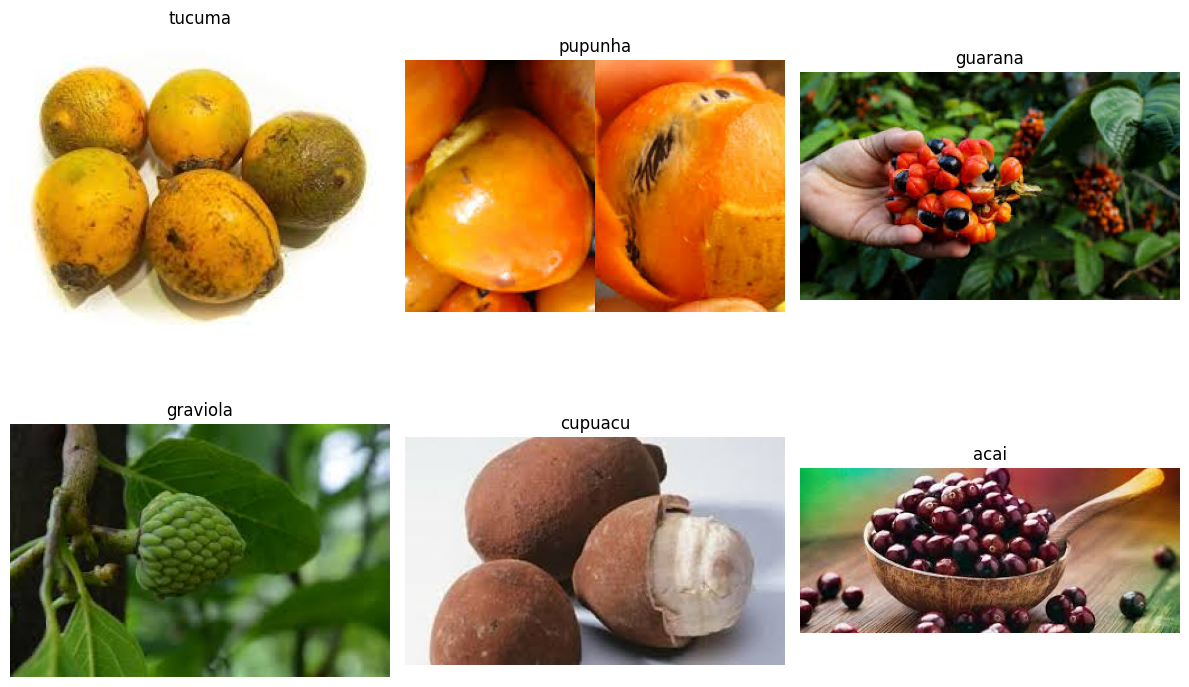

In [ ]:
#List of class directories
class_dirs = os.listdir(train_df)

#List to hold the images and labels
images = []
labels = []

for class_name in class_dirs:
  class_path = os.path.join(train_df, class_name)
  image_files = os.listdir(class_path)

  #Select a random image from each class
  random_image = random.choice(image_files)
  random_image_path = os.path.join(class_path, random_image)

  images.append(mpimg.imread(random_image_path))
  labels.append(class_name)

#Plot the images in 2 rows, divide the columns accordingly
fig, axes = plt.subplots(nrows=2, ncols=len(class_dirs)//2, figsize=(12, 8))
axes = axes.ravel()

for i in range(len(images)):
  ax = axes[i]
  ax.imshow(images[i])
  ax.set_title(labels[i])
  ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#List to store path to corrupted images
corrupted_images = []

#Iterate through each class directory
for class_name in class_dirs:
  class_path = os.path.join(train_df, class_name)
  #Ensure it's a directory
  if os.path.isdir(class_path):
      #Iterate through all image files in the class directory
      for image_name in os.listdir(class_path):
          image_path = os.path.join(class_path, image_name)

          #Check if the file is an image (assuming common formats)
          if image_path.lower().endswith(('jpg', 'jpeg', 'png', 'gif')):
              try:
                  #Try to open the image
                  with Image.open(image_path) as img:
                      img.verify()  # verify the image is not corrupted
                      width, height = img.size

                      #Print the height
              except (IOError, SyntaxError) as e:
                  #If an error occurs, it means the image is corrupted
                  corrupted_images.append(image_path)
                  os.remove(image_path)  # remove the corrupted image
                  print(f"Removed corrupted image: {image_path}")

#Check if any corrupted images were found
if not corrupted_images:
    print("No corrupted images found.")

No corrupted images found.


In [ ]:
#Data preparation
#Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,  #Normalize pixel values to [0, 1]
    validation_split=0.2
)

#Create training and validation data generators
train_generator = datagen.flow_from_directory(
    train_df,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',  # Use 'sparse' for integer labels
    subset='training',
    seed=1337
)

#Create a separate ImageDataGenerator for validation (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Create validation generator without augmentations
validation_generator = val_datagen.flow_from_directory(
    train_df,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False  #Important: Keep order consistent
)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [ ]:
image_size = (128, 128)
batch_size = 64

In [ ]:
def build_improved_model(input_shape=(128, 128, 3), num_classes=6):
    model = keras.Sequential([
        #Data augmentation and rescaling
        layers.Input(shape=input_shape),

        #First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        #Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        #Third Convolutional Block
        layers.Conv2D(128, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        #Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(256, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        #Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
#Create and compile model
model = build_improved_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.1869 - loss: 2.7023 - val_accuracy: 0.1667 - val_loss: 2.4646
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.3935 - loss: 1.8747 - val_accuracy: 0.1667 - val_loss: 2.2445
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3750 - loss: 1.6272 - val_accuracy: 0.1667 - val_loss: 2.0852
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 10s/step - accuracy: 0.3472 - loss: 2.2646 - val_accuracy: 0.2222 - val_loss: 2.0265
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 782ms/step - accuracy: 0.5341 - loss: 1.3958 - val_accuracy: 0.3333 - val_loss: 2.1127
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.6713 - loss: 1.0218 - val_accuracy: 0.3333 - val_loss: 2.2438
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5382 - loss: 1.4904 - val_accuracy: 0.3333 - val_loss: 2.2408


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_df,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',
    seed=1337,
    shuffle=False
)

Found 30 images belonging to 6 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - accuracy: 0.2333 - loss: 2.0085
Test accuracy: 0.2333


In [ ]:
test_generator_1 = test_datagen.flow_from_directory(
    test_df,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    seed=1337
)

Found 30 images belonging to 6 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_generator_1)
print(f"Test accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2333 - loss: 2.0085
Test accuracy: 0.2333


TASK 2

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
class_names = sorted(os.listdir(train_df))

In [ ]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model except from block conv 5
base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
#Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

#Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
#Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 7,610,886 (29.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:

#Create training and validation data generators
train_generator = datagen.flow_from_directory(
    train_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',  # Use 'sparse' for integer labels
    subset='training',
    seed=1337
)

#Create a separate ImageDataGenerator for validation (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Create validation generator without augmentations
validation_generator = val_datagen.flow_from_directory(
    train_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False  # Important: Keep order consistent
)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [ ]:
model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 70s 61s/step - accuracy: 0.0833 - loss: 3.7673 - val_accuracy: 0.1667 - val_loss: 1.8010
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 68s/step - accuracy: 0.2361 - loss: 2.3547 - val_accuracy: 0.1667 - val_loss: 2.0770
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 26s/step - accuracy: 0.1580 - loss: 2.0301 - val_accuracy: 0.1667 - val_loss: 1.8063
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 58s/step - accuracy: 0.0926 - loss: 1.8484 - val_accuracy: 0.1667 - val_loss: 1.7910
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 68s/step - accuracy: 0.1528 - loss: 1.7906 - val_accuracy: 0.1667 - val_loss: 1.7928
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 71s 17s/step - accuracy: 0.1580 - loss: 1.7899 - val_accuracy: 0.1667 - val_loss: 1.8135
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 59s/step - accuracy: 0.1111 - loss: 1.8334 - val_accuracy: 0.1667 - val_loss: 1.7912
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 89s 68s/step - accuracy: 0.1944 - loss: 1.7899 - val_accuracy: 0.1667 - val_loss: 1.7894


New Model

In [ ]:
train_generator_2 = datagen.flow_from_directory(
    train_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='training',
    seed=1337
)

#Create a separate ImageDataGenerator for validation (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Create validation generator without augmentations
validation_generator_2 = val_datagen.flow_from_directory(
    train_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False  #Important: Keep order consistent
)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [ ]:
#Load pre-trained VGG16 model
base_model_224 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze all layers in the base model
for layer in base_model_224.layers:
    layer.trainable = False

#Add custom layers on top
x224 = base_model_224.output
x224 = GlobalAveragePooling2D()(x224)
x224 = Dense(1024, activation='relu')(x224)
predictions224 = Dense(len(class_names), activation='softmax')(x224)

#Create final model
model224 = Model(inputs=base_model_224.input, outputs=predictions224)

#Compile the model
model224.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#Display model summary
model224.summary()

#Train the model
history224 = model224.fit(
    train_generator_2,
    validation_data=validation_generator_2,
    epochs=15,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

#Evaluate the model
val_loss224, val_acc224 = model224.evaluate(validation_generator_2)
print(f"Validation Accuracy: {val_acc224:.4f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 50s/step - accuracy: 0.1343 - loss: 1.9751 - val_accuracy: 0.1667 - val_loss: 1.9308
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 66s 59s/step - accuracy: 0.2315 - loss: 1.7935 - val_accuracy: 0.2778 - val_loss: 1.7619
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 49s/step - accuracy: 0.3148 - loss: 1.6605 - val_accuracy: 0.2778 - val_loss: 1.5881
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 86s 51s/step - accuracy: 0.3981 - loss: 1.5489 - val_accuracy: 0.4444 - val_loss: 1.5824
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 16s/step - accuracy: 0.4566 - loss: 1.4934 - val_accuracy: 0.3889 - val_loss: 1.5415
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 16s/step - accuracy: 0.5237 - loss: 1.4095 - val_accuracy: 0.4444 - val_loss: 1.4147
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 81s 16s/step - accuracy: 0.6105 - loss: 1.2598 - val_accuracy: 0.5000 - val_loss: 1.3574
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 16s/step - accuracy: 0.6684 - loss: 1.2002 - val_accuracy: 0.5556 - val_loss: 1.3222


In [ ]:
#Ensure the validation generator does NOT shuffle
validation_generator_2.shuffle = False

#Get true labels
true_labels = validation_generator_2.classes

#Get class labels in correct order
class_labels = list(validation_generator_2.class_indices.keys())

#Make predictions
pred_probs = model224.predict(validation_generator_2)

#Convert predictions to class labels
pred_labels = np.argmax(pred_probs, axis=1)

#Print classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
Classification Report
              precision    recall  f1-score   support

        acai       1.00      0.33      0.50         3
     cupuacu       0.43      1.00      0.60         3
    graviola       1.00      0.67      0.80         3
     guarana       0.40      0.67      0.50         3
     pupunha       0.50      0.33      0.40         3
      tucuma       1.00      0.33      0.50         3

    accuracy                           0.56        18
   macro avg       0.72      0.56      0.55        18
weighted avg       0.72      0.56      0.55        18



In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator_2 = test_datagen.flow_from_directory(
    test_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    seed=1337,
    shuffle=False
)

Found 30 images belonging to 6 classes.


In [ ]:
#Evaluate the model
test_loss224, test_acc224 = model224.evaluate(test_generator_2)
print(f"Test Accuracy: {test_acc224:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.6000 - loss: 1.2864
Test Accuracy: 0.6000


In [ ]:
#Ensure the validation generator does NOT shuffle
test_generator_2.shuffle = False

#Get true labels
true_labels = test_generator_2.classes

#Get class labels in correct order
class_labels = list(test_generator_2.class_indices.keys())

#Make predictions
pred_probs = model224.predict(test_generator_2)

#Convert predictions to class labels
pred_labels = np.argmax(pred_probs, axis=1)

#Print classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
Classification Report
              precision    recall  f1-score   support

        acai       0.50      0.20      0.29         5
     cupuacu       0.60      0.60      0.60         5
    graviola       0.83      1.00      0.91         5
     guarana       0.57      0.80      0.67         5
     pupunha       0.50      0.40      0.44         5
      tucuma       0.50      0.60      0.55         5

    accuracy                           0.60        30
   macro avg       0.58      0.60      0.58        30
weighted avg       0.58      0.60      0.58        30



In [ ]:
#Print each sample's true vs. predicted label
print("\nTrue Label  |  Predicted Label")
print("-" * 30)

for i in range(len(true_labels)):
    true_class = class_labels[true_labels[i]]  #Get true class name
    pred_class = class_labels[pred_labels[i]]  #Get predicted class name
    print(f"{true_class:<12} |  {pred_class}")


True Label  |  Predicted Label
------------------------------
acai         |  acai
acai         |  guarana
acai         |  graviola
acai         |  cupuacu
acai         |  guarana
cupuacu      |  cupuacu
cupuacu      |  pupunha
cupuacu      |  cupuacu
cupuacu      |  guarana
cupuacu      |  cupuacu
graviola     |  graviola
graviola     |  graviola
graviola     |  graviola
graviola     |  graviola
graviola     |  graviola
guarana      |  guarana
guarana      |  cupuacu
guarana      |  guarana
guarana      |  guarana
guarana      |  guarana
pupunha      |  tucuma
pupunha      |  pupunha
pupunha      |  pupunha
pupunha      |  tucuma
pupunha      |  tucuma
tucuma       |  tucuma
tucuma       |  tucuma
tucuma       |  acai
tucuma       |  tucuma
tucuma       |  pupunha
